Målet er å nøyaktig anslå lengden på sykehusopphold for nye pasienter basert på disse variablene.


## 1 Importer de nødvendige modulene og leser filene

python pakker lovlige
xlrd, numpy, pandas, polars, scipy, sklearn, matplotlib, seaborn, requests, plotly, flask, django, waitress.

In [314]:
import numpy as np 
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression



In [315]:
demographic_df = pd.read_csv("../raw_data/demographic.csv")
hospital_df = pd.read_csv("../raw_data/hospital.csv")
physiological_df = pd.read_csv("../raw_data/physiological.txt", delimiter='\t')
severity_df = pd.read_json("../raw_data/severity.json")



# 2.0 Data forbredelse

I denne delen skal jeg forstå dataen og inneholdet, rense dataen, lage nye variabler (features), normalisere/standarise nummeriske variabler og splitte data i treningssett, valideringssett og testsett

### 2.1 Funksjoner

Lager forhåndsdefinerte funksjoner, så slipper redundans av kode

Onehot_encode
Teknikk på å kunne represenetere kategoriske variabler som nummeriske variabler for å passe i en maskinlæringsmodell

In [316]:

def one_hot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df, *columns):
    df = df.copy()
    for column in columns:
        df = one_hot_encode(df, column)
    return df

Histogram for nummeriske variabler som vi vil se sammenhengen til

In [317]:
def histogram(df ):
    for i in df.columns:
        fig = px.histogram(df, x=i, title=i)
        fig.show()

### 2.2 Hospital dataframen

Datafilen inneholder korrelasjonen mellom hvor lenge en pasient befant seg på sykehuset og om pasientet døde på sykehuset. 

In [318]:
hospital_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   pasient_id      7740 non-null   int64
 1   sykehusdød      7740 non-null   int64
 2   oppholdslengde  7740 non-null   int64
dtypes: int64(3)
memory usage: 181.5 KB


In [319]:
#noen av variablene har  negativoppholdslengde, 
#Siden vi ikke er interessert i å se på variabler med negativ oppholdslengde, fjerner vi radene

negativ_oppholdslengde = hospital_df[hospital_df["oppholdslengde"] < 0]
print(negativ_oppholdslengde["oppholdslengde"])

hospital_df = hospital_df[hospital_df["oppholdslengde"] >= 0]


3      -99
20     -99
83     -99
216    -99
438    -99
6802   -99
Name: oppholdslengde, dtype: int64


Fjerner sykehusdød, er ikke relevant til å vite om personen dør, oppholdet vil uansett stoppe da

In [320]:
hospital_df = hospital_df.drop(["sykehusdød"], axis=1)

In [321]:
#se oppholdslengden
hosptial_num = hospital_df[["oppholdslengde"]]
histogram(hosptial_num)

### 2.3 Demographic dataframe

 Demographic dataframe

I denne datafilen ser vi korrelasjonen mellom demografisk data. Dette kan gi oss et innsikt i hvordan det demografiske spiller inn i korrelasjon med sykehuset. 
Dette settet inneholder både kategoriske og nummeriske variabler, som vi burde analysere videre.

In [322]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pasient_id  7742 non-null   int64  
 1   alder       7742 non-null   float64
 2   kjønn       7742 non-null   object 
 3   utdanning   6360 non-null   float64
 4   inntekt     5223 non-null   object 
 5   etnisitet   7705 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 363.0+ KB


In [323]:
#sjekker om noe alder data er negative
negativ_alder = demographic_df[demographic_df["alder"] < 0]
print(negativ_alder) 

#konverter fra negativ alder, til NaN
#antar vi er en feil i dataene, og gjør det om til NaN
demographic_df.loc[demographic_df['alder'] < 0, 'alder'] = np.nan

#runder ned alle aldere, ifølge loven er man ikke en hvis alder før dagen man fyller alderen. 
demographic_df["alder"] = np.floor(demographic_df["alder"])




     pasient_id  alder   kjønn  utdanning     inntekt etnisitet
13           15   -1.0  female        NaN         NaN     white
93          112   -1.0  female       12.0  under $11k     white
219         259   -1.0    male       13.0         NaN       NaN
359         421   -1.0    male        NaN         NaN     black
868        1002   -1.0    male       12.0    $25-$50k     black


Se på nummeriske og kategoriske variabler hver for seg i dataframen

In [324]:
demographic_num = demographic_df[["alder", "utdanning"]]
demographic_cat = demographic_df[["kjønn", "inntekt", "etnisitet"]]

In [325]:
#nummerisk variabler spredning
histogram(demographic_num)

In [326]:
histogram(demographic_cat)

alder ser gjevn ut
Men vi ser at utdanning har majoritet på 12 år, dette skal vi prøve å løse ved å normalisere


I de kategoriske variablene ser vi at etnistet har en  stort antall hvite og mindre på minoritetene, for å deale med dette samler vi minoritetene 

In [327]:


demographic_df["etnisitet"] = demographic_df["etnisitet"].replace({"black": "other", "hispanic": "other", "asian": "other", "other": "other"})

In [328]:
histogram(demographic_df[["etnisitet"]])



Lager dummy variabler av de kategoriske variablene

In [329]:
demographic_df = preprocess_inputs(demographic_df, ["kjønn", "inntekt", "etnisitet"])


Sjekker korrelasjon 

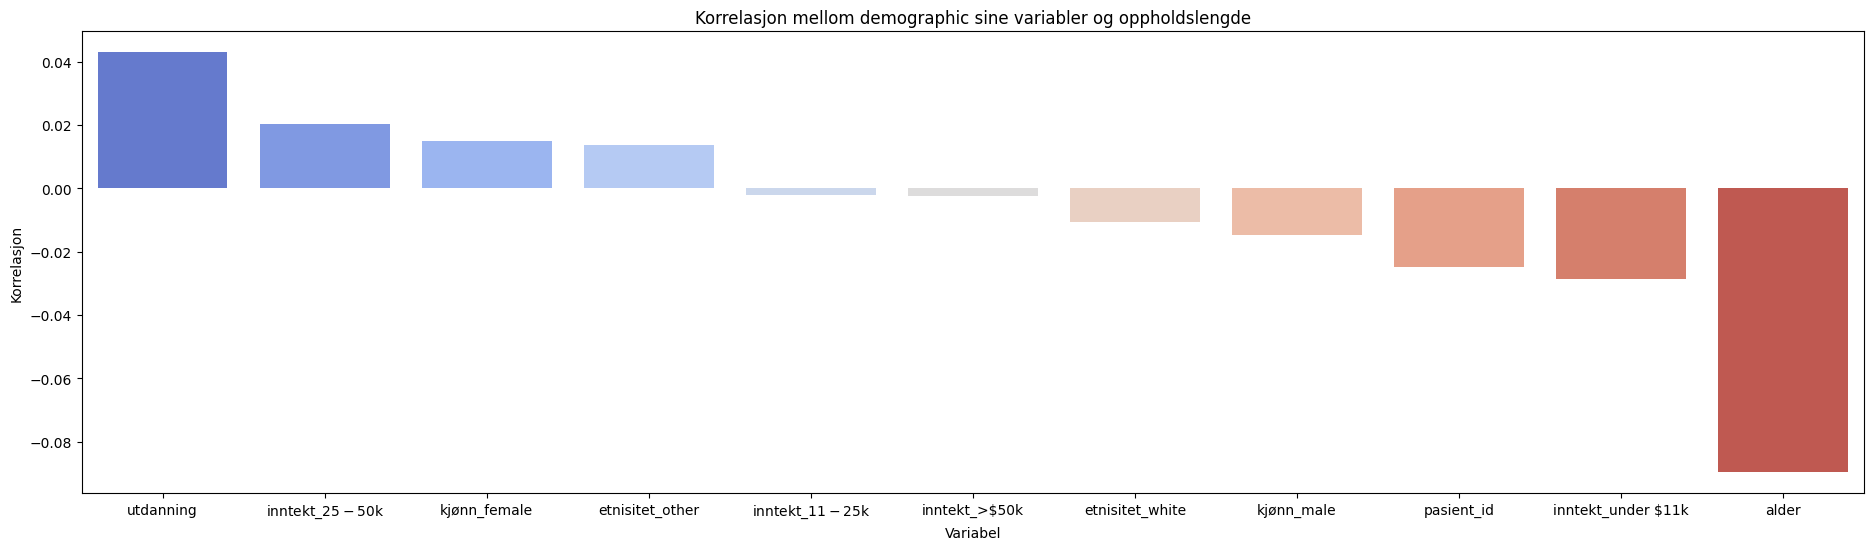

In [330]:
demographic_dict = {}

for kolonne in demographic_df:
    korrelasjon = demographic_df[kolonne].corr(hospital_df["oppholdslengde"])
    demographic_dict[kolonne] = korrelasjon


demographic_korrelasjon = pd.DataFrame(list(demographic_dict.items()), columns=['Variabel', 'Korrelasjon']).sort_values(by = "Korrelasjon",   ascending=False)

plt.figure(figsize=(23, 6))
sns.barplot(x="Variabel", y="Korrelasjon", data=demographic_korrelasjon, palette="coolwarm", hue="Variabel")
plt.title("Korrelasjon mellom demographic sine variabler og oppholdslengde")
plt.xlabel("Variabel")
plt.ylabel("Korrelasjon")
plt.show()

### 2.4 Physiological

In [331]:
physiological_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pasient_id            7740 non-null   int64  
 1   blodtrykk             7740 non-null   float64
 2   hvite_blodlegemer     7565 non-null   float64
 3   hjertefrekvens        7740 non-null   float64
 4   respirasjonsfrekvens  7740 non-null   float64
 5   kroppstemperatur      7740 non-null   float64
 6   lungefunksjon         5796 non-null   float64
 7   serumalbumin          4891 non-null   float64
 8   bilirubin             5544 non-null   float64
 9   kreatinin             7683 non-null   float64
 10  natrium               7740 non-null   float64
 11  blod_ph               5828 non-null   float64
 12  glukose               3917 non-null   float64
 13  blodurea_nitrogen     4048 non-null   float64
 14  urinmengde            3627 non-null   float64
dtypes: float64(14), int64

Vi ser at en del av variablene har Null verdier

In [332]:
#vi trenger ikke å ha med bilirubin, siden dette får vi ikke målt før dag 7, ikke relveant til å predikere sykehusopphold.
physiological_df = physiological_df.drop("bilirubin", axis=1)

In [333]:
physiological_nan = physiological_df.isna().mean() * 100
print(physiological_nan)

pasient_id               0.000000
blodtrykk                0.000000
hvite_blodlegemer        2.260982
hjertefrekvens           0.000000
respirasjonsfrekvens     0.000000
kroppstemperatur         0.000000
lungefunksjon           25.116279
serumalbumin            36.808786
kreatinin                0.736434
natrium                  0.000000
blod_ph                 24.702842
glukose                 49.392765
blodurea_nitrogen       47.700258
urinmengde              53.139535
dtype: float64


Vi fyller inn de manglenede Nan verdiene med data fra https://hbiostat.org/data/repo/supportdesc fra Professor Frank Harrell
Dette er baseline verdier som kan brukes til å håndtere manglende data

In [334]:

physiological_df['serumalbumin'] = physiological_df['serumalbumin'].fillna(3.5)
physiological_df['lungefunksjon'] = physiological_df['lungefunksjon'].fillna(333.3)
physiological_df['kreatinin'] = physiological_df['kreatinin'].fillna(1.01)
physiological_df['hvite_blodlegemer'] = physiological_df['hvite_blodlegemer'].fillna(9)
physiological_df['blodurea_nitrogen'] = physiological_df['blodurea_nitrogen'].fillna(6.51)
physiological_df['urinmengde'] = physiological_df['urinmengde'].fillna(2502)


Sjekker om variablene har noe korrelasjon med sykehusopphold, dersom høy mengde NaN verdier fjerner vi variablene.

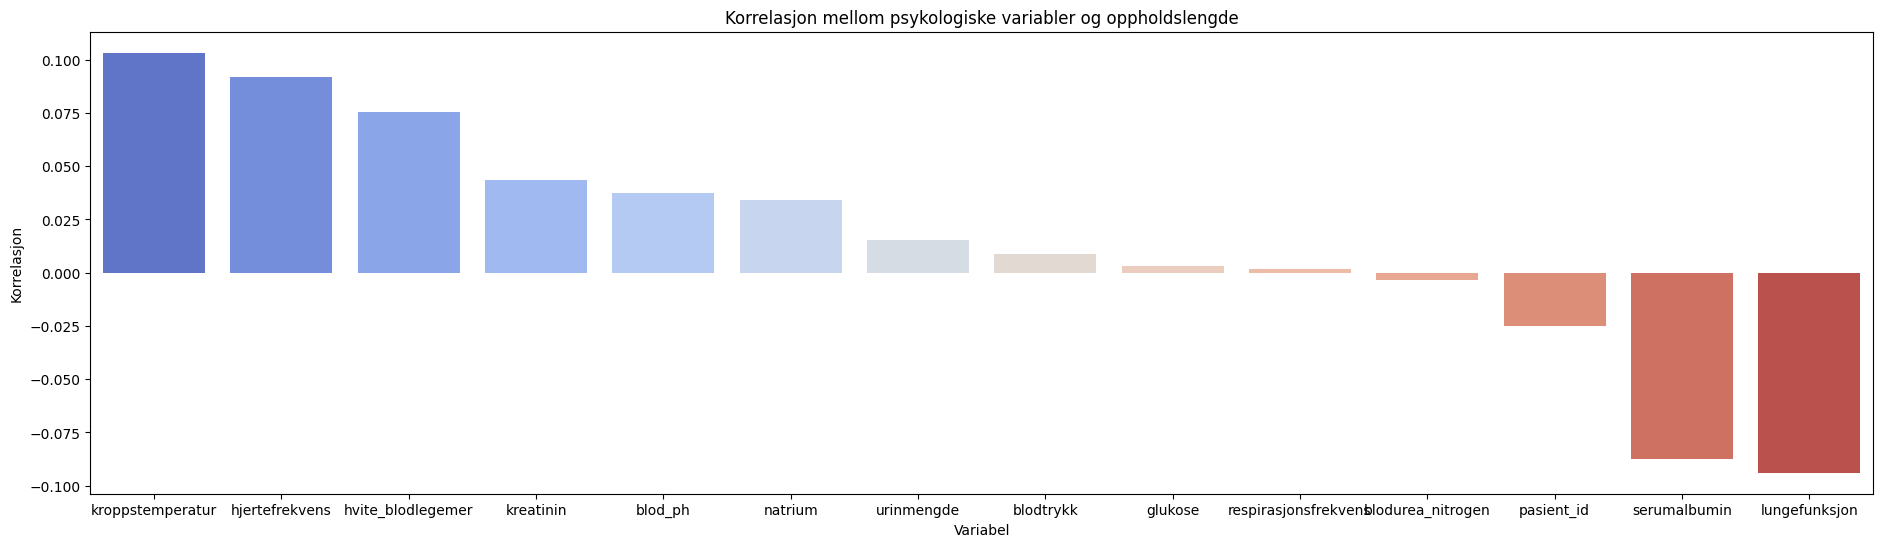

In [335]:
physiological_dict = {}

for kolonne in physiological_df:
    korrelasjon = physiological_df[kolonne].corr(hospital_df["oppholdslengde"])
    physiological_dict[kolonne] = korrelasjon


physiological_korrelasjon = pd.DataFrame(list(physiological_dict.items()), columns=['Variabel', 'Korrelasjon']).sort_values(by = "Korrelasjon",   ascending=False)

plt.figure(figsize=(23, 6))
sns.barplot(x="Variabel", y="Korrelasjon", data=physiological_korrelasjon, palette="coolwarm", hue="Variabel")
plt.title("Korrelasjon mellom psykologiske variabler og oppholdslengde")
plt.xlabel("Variabel")
plt.ylabel("Korrelasjon")
plt.show()

In [336]:
physiological_df = physiological_df.drop(columns="glukose")

In [337]:
physiological_summary = physiological_df.describe()
print(physiological_summary)

        pasient_id    blodtrykk  hvite_blodlegemer  hjertefrekvens  \
count  7740.000000  7740.000000        7740.000000     7740.000000   
mean   4540.665375    84.412468          12.227368       97.283940   
std    2636.463416    27.713746           9.017879       31.499505   
min       2.000000     0.000000           0.000000        0.000000   
25%    2244.750000    63.000000           7.000000       72.000000   
50%    4539.500000    77.000000          10.398438      100.000000   
75%    6816.250000   107.000000          15.099609      120.000000   
max    9105.000000   195.000000         128.781250      232.000000   

       respirasjonsfrekvens  kroppstemperatur  lungefunksjon  serumalbumin  \
count           7740.000000       7740.000000    7740.000000   7740.000000   
mean              23.348450         37.116579     263.140228      3.154105   
std                9.549561          1.257278     103.452022      0.754716   
min                0.000000         31.699220      12.000

### 2.5 Severity Data JSON

Omformatterer json filen fra JSON til en dataframe

In [338]:
severity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   sykdomskategori_id             4 non-null      object
 1   sykdomskategori                4 non-null      object
 2   pasient_id                     4 non-null      object
 3   dødsfall                       4 non-null      object
 4   sykdom_underkategori           4 non-null      object
 5   antall_komorbiditeter          4 non-null      object
 6   koma_score                     4 non-null      object
 7   adl_pasient                    4 non-null      object
 8   adl_stedfortreder              4 non-null      object
 9   fysiologisk_score              4 non-null      object
 10  apache_fysiologisk_score       4 non-null      object
 11  overlevelsesestimat_2mnd       4 non-null      object
 12  overlevelsesestimat_6mnd       4 non-null      object
 13  diabetes      

In [339]:
severity_df

,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,A1s,ARF/MOSF,"[5, 15, 18, 23, 28, 34, 39, 43, 46, 47, 48, 58...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...","[ARF/MOSF w/Sepsis, ARF/MOSF w/Sepsis, ARF/MOS...","[1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 3, 1, 3, ...","[26.0, 26.0, 26.0, 0.0, 26.0, 37.0, 0.0, 0.0, ...","[None, None, None, None, None, None, None, Non...","[2.0, None, 0.0, 5.0, 2.0, None, 0.0, None, No...","[23.5, 30.5, 40.296875, 31.6992188, 46.796875,...","[30.0, 39.0, 58.0, 42.0, 85.0, 49.0, 5.0, 76.0...","[0.6348876950000001, 0.590942383, 0.2129821780...","[0.5329589840000001, 0.481994629, 0.1169891360...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, yes,...","[0.899999619, 0.899999619, 0.09999996400000001...","[0.9, 0.9, 0.001, 0.5, 0.000125, 0.60000000000...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
1,BrY,COPD/CHF/Cirrhosis,"[2, 3, 7, 8, 11, 13, 14, 19, 20, 30, 31, 32, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[Cirrhosis, Cirrhosis, CHF, CHF, CHF, Cirrhosi...","[2, 2, 1, 3, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, ...","[44.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[None, 1.0, 0.0, None, 2.0, 0.0, 0.0, 7.0, 3.0...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 7.0, None,...","[52.6953125, 20.5, 17.296875, 21.5976562, 14.5...","[74.0, 45.0, 46.0, 53.0, 14.0, 30.0, 34.0, 42....","[0.000999928, 0.790893555, 0.892944336, 0.6708...","[0.0, 0.6649169920000001, 0.820922852, 0.49896...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, no, no, no, no, no, no, no, n...","[0.0, 0.75, None, 0.799999714, 0.699999809, No...","[0.0, 0.5, 0.7000000000000001, 0.4, 0.5, None,...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
2,ChE,Cancer,"[4, 9, 10, 12, 16, 17, 21, 24, 27, 41, 42, 54,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[Lung Cancer, Lung Cancer, Colon Cancer, Lung ...","[2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 0, 1, ...","[0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0...","[0.0, None, 0.0, 1.0, 2.0, None, 0.0, None, No...","[0.0, 7.0, None, 1.0, 0.0, None, 0.0, None, No...","[20.0976562, 15.8984375, 2.2998047, 16.3984375...","[19.0, 17.0, 9.0, 17.0, 11.0, 4.0, 16.0, 11.0,...","[0.6989746090000001, 0.570922852, 0.9528808590...","[0.411987305, 0.24899292, 0.8879394530000001, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[metastatic, metastatic, metastatic, metastati...","[0.899999619, 0.049999982000000005, None, None...","[0.5, 0.000125, None, None, 0.7000000000000001...","[None, dnr ved innleggelse, None, None, None, ...","[None, 0.0, None, None, None, None, None, None..."
3,DWw,Coma,"[6, 162, 188, 250, 252, 262, 275, 309, 323, 35...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[Coma, Coma, Coma, Coma, Coma, Coma, Coma, Com...","[1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, ...","[55.0, 61.0, 94.0, 55.0, 94.0, 100.0, 100.0, 5...","[None, None, None, None, None, None, None, Non...","[1.0, None, None, 1.0, None, None, None, None,...","[19.3984375, 30.3984375, 20.296875, 30.8984375...","[27.0, 36.0, 22.0, 53.0, 40.0, 25.0, 58.0, 16....","[0.28497314500000004, 0.438964844, 0.280944824...","[0.214996338, 0.365966797, 0.211975098, 0.2729...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, no, ...","[0.0, None, None, None, None, 0.09999996400000...","[0.0, None, N

In [340]:
severity_df = severity_df.explode(["pasient_id", "dødsfall", "sykdom_underkategori", "antall_komorbiditeter", "koma_score", 
                                              "adl_pasient", "adl_stedfortreder", "fysiologisk_score", "apache_fysiologisk_score", "overlevelsesestimat_2mnd",
                                              "overlevelsesestimat_6mnd", "diabetes", "demens","kreft", "lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd",
                                              "dnr_status", "dnr_dag"])

severity_df.set_index('pasient_id', inplace=True)

severity_df = severity_df.drop("dødsfall", axis=1)

#kolonner som skal være nummeriske, konverter til nummeriske verdier
numerical_columns = ['antall_komorbiditeter', 'koma_score', 'fysiologisk_score', 
                     'apache_fysiologisk_score', 'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 
                     'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd', "dnr_dag", 
                     "adl_stedfortreder", "adl_pasient" ]

severity_df[numerical_columns] = severity_df[numerical_columns].apply(pd.to_numeric, errors='coerce')



In [341]:
severity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7740 entries, 5 to 9102
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sykdomskategori_id             7740 non-null   object 
 1   sykdomskategori                7740 non-null   object 
 2   sykdom_underkategori           7740 non-null   object 
 3   antall_komorbiditeter          7740 non-null   int64  
 4   koma_score                     7740 non-null   float64
 5   adl_pasient                    2942 non-null   float64
 6   adl_stedfortreder              5299 non-null   float64
 7   fysiologisk_score              7740 non-null   float64
 8   apache_fysiologisk_score       7740 non-null   float64
 9   overlevelsesestimat_2mnd       7740 non-null   float64
 10  overlevelsesestimat_6mnd       7740 non-null   float64
 11  diabetes                       7740 non-null   object 
 12  demens                         7740 non-null   object

Vi får ikke vite målingene på adl_pasient før dag 7, ikke relevant til modellen jeg skal lage

In [342]:
severity_df = severity_df.drop("adl_pasient", axis=1)

Dummy variabler for kateogriske variabler

In [343]:
severity_df = preprocess_inputs(severity_df, ["sykdomskategori_id", "sykdomskategori", 
                                              "sykdom_underkategori", 
                                              "diabetes", 
                                              "demens", "kreft", "dnr_status"])


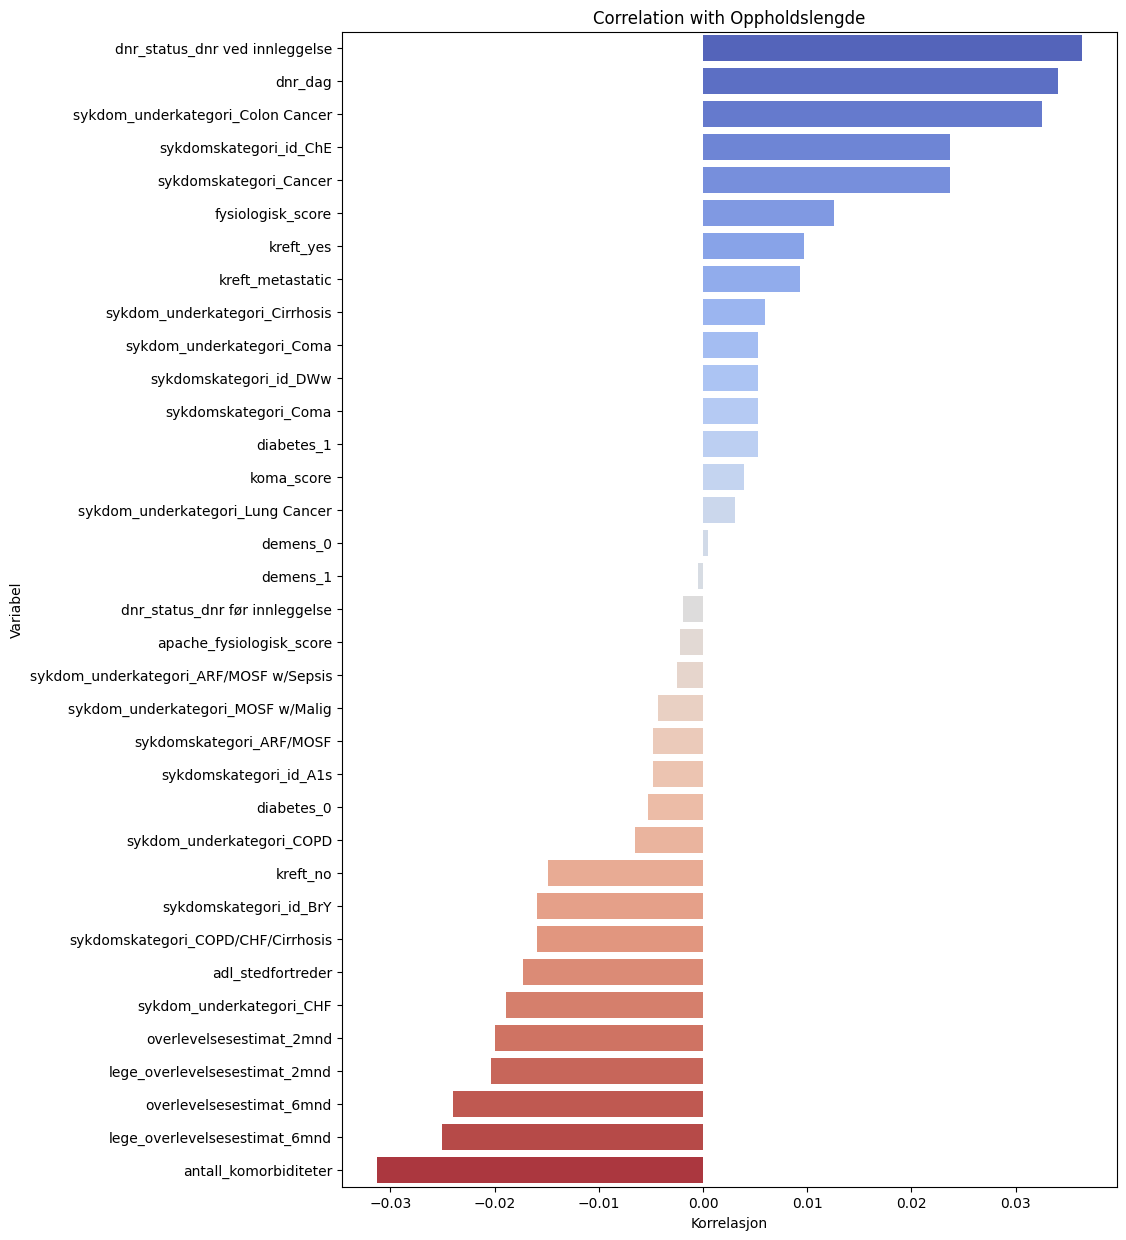

In [344]:
severity_dict = {}

for kolonne in severity_df:
    korrelasjon = severity_df[kolonne].corr(hospital_df["oppholdslengde"])
    severity_dict[kolonne] = korrelasjon

severity_korrelasjon = pd.DataFrame(list(severity_dict.items()), columns=['Variabel', 'Korrelasjon']).sort_values(by="Korrelasjon", ascending=False)


plt.figure(figsize=(10, 15))
sns.barplot(y="Variabel", x="Korrelasjon", data=severity_korrelasjon, palette="coolwarm", hue="Variabel")
plt.title("Correlation with Oppholdslengde")
plt.xlabel("Korrelasjon")
plt.ylabel("Variabel")
plt.show()

In [345]:
severity_nan = severity_df.isna().mean() * 100
print(severity_nan)

antall_komorbiditeter                      0.000000
koma_score                                 0.000000
adl_stedfortreder                         31.537468
fysiologisk_score                          0.000000
apache_fysiologisk_score                   0.000000
overlevelsesestimat_2mnd                   0.000000
overlevelsesestimat_6mnd                   0.000000
lege_overlevelsesestimat_2mnd             18.359173
lege_overlevelsesestimat_6mnd             18.178295
dnr_dag                                   86.175711
sykdomskategori_id_A1s                     0.000000
sykdomskategori_id_BrY                     0.000000
sykdomskategori_id_ChE                     0.000000
sykdomskategori_id_DWw                     0.000000
sykdomskategori_ARF/MOSF                   0.000000
sykdomskategori_COPD/CHF/Cirrhosis         0.000000
sykdomskategori_Cancer                     0.000000
sykdomskategori_Coma                       0.000000
sykdom_underkategori_ARF/MOSF w/Sepsis     0.000000
sykdom_under

dnr dag har 86% NaN verdier og høy korrelasjon med sykehusopphold. 
Databeskrivelsen forklarer oss at 
<0, DNR-ordren ble gitt før pasienten ble inkludert i studien (eller før innleggelsen).
0 DNR-ordren ble gitt på innleggelsesdagen.
NaN: Ordren ble gitt etter innleggelsen


In [346]:
#gjør om NAn verdier til 1, dette indikerer at paisenten fikk orderen etter innleggelsen
severity_df.fillna({'dnr_dag': 1}, inplace=True)

histogram(severity_df[["dnr_dag"]])

### 2.6 Merger dataframenene

In [347]:


merged_df = pd.merge(demographic_df, hospital_df, on="pasient_id") #merger først demographic og sykehus data
merged_2_df = pd.merge(merged_df, physiological_df, on="pasient_id") #merger sammen det medisinske 
df = pd.merge(merged_2_df, severity_df, on="pasient_id") #merger sammen severity data med resten


In [348]:
df

,pasient_id,alder,utdanning,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,etnisitet_other,...,sykdom_underkategori_MOSF w/Malig,diabetes_0,diabetes_1,demens_0,demens_1,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse
0,2,60.0,12.0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,3,52.0,12.0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
2,4,42.0,11.0,1,0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,0,0
3,6,93.0,14.0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,7,62.0,14.0,0,1,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,9103,70.0,NaN,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
7732,9104,47.0,13.0,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
7733,9105,81.0,8.0,1,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
7734,59,72.0,NaN,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1


Larger om til csv

In [349]:
df.to_csv("./arbeid.csv")

### 2.7 Dataframen

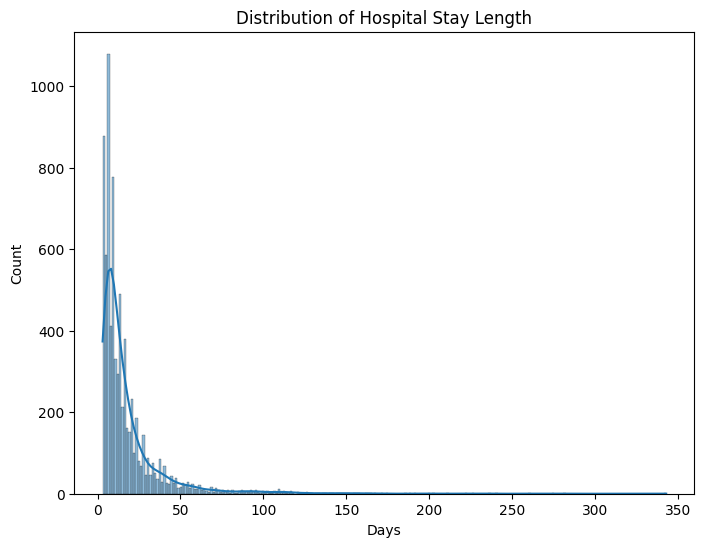

In [350]:
plt.figure(figsize=(8, 6))
sns.histplot(df['oppholdslengde'], kde=True)
plt.title('Distribution of Hospital Stay Length')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

# 3.0 Trene modell 

### 3.1 Forbredelse av data 

Deler data i trenings, validerings og testdata med størrelser 70%, 15% og 15%

- Treningsdata bruker vi til å tilpasse modellen

- Valideringsdata bruker vi for å velge endelige modellen 

- Testdata bruker vi for en objektiv evaluering av den endelige modellen





In [351]:
X = df.drop(columns="oppholdslengde") 
y = df["oppholdslengde"]


X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [352]:
imputer = SimpleImputer(strategy='mean')  

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

scaler = StandardScaler()
scaler.fit(X_train_imputed)

X_train = pd.DataFrame(scaler.transform(X_train_imputed), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test_imputed), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val_imputed), columns=X.columns)


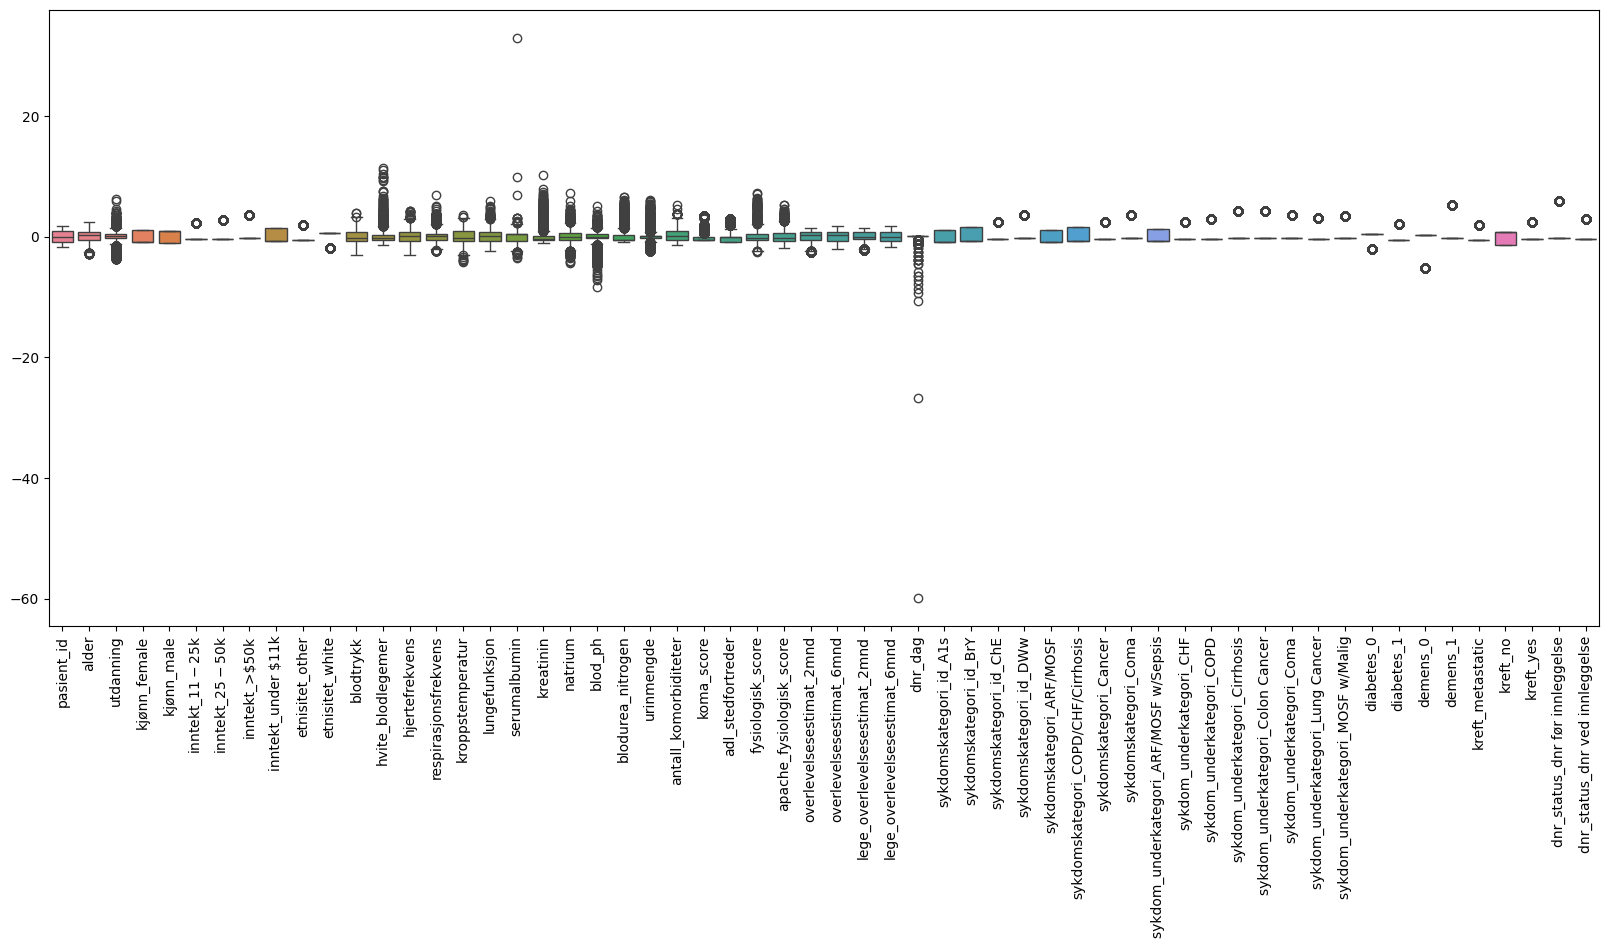

In [353]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=X_train)
plt.xticks(rotation=90)
plt.show()

### 3.2 Før vi starter modelleringen så ser vi på treningsdata

### 3.3 Trening

Første modellen vi alltid lager er en grunnlinjemodell

In [354]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_baseline = baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))


Linær reggresjon

In [355]:
regr = LinearRegression() 
regr.fit(X_train, y_train) 
y_pred_regr =  regr.predict(X_val)
rmse_regr = np.sqrt(mean_squared_error(y_val, y_pred_regr))

Lasso, å finne rikitg alpha er vanskelig å gjette seg fram, derfor finner vi best alpha verdi ved kryss evaluering

In [356]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_

print("Best alpha:", best_alpha)

y_pred_lasso = lasso_cv.predict(X_val)

rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))


Best alpha: 0.015199110829529346


Random Forest-modell

In [357]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

RMSE for modellene

In [358]:
print(f"Baseline {rmse_baseline}")
print(f"Linær reggresjon {rmse_regr}")
print(f"Lasso {rmse_lasso}")
print(f"Random Forest-modell {rmse_rf}")


Baseline 19.266474721683945
Linær reggresjon 17.75040182105384
Lasso 17.723129213597296
Random Forest-modell 19.118442477320706


Lasso modellen predikerer best, og vi får en gjennomsnittlig avvik på sykehusopphold med 17.7 dager, dette er veldig lovende tall

## Visualiserer dataene